In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [6]:
def intersection(sets):
    return list(set.intersection(*map(set, sets)))    

In [7]:
def exclusion(Node_A, Node_B):
    try:
        excluded = [x for x in Node_A if x not in Node_B]
    except:
        excluded = [x for x in Node_A if x!=Node_B]
    return excluded

In [8]:
def largestVertex(G, SUBG, CAND):
    intersectionLength = []
    for node in SUBG:
        intersectionLength.append( len(intersection([list(G.neighbors(node)), list(CAND.nodes())])))
    index = np.where(intersectionLength == np.max(intersectionLength))
    return list(SUBG.nodes())[index[0][0]]

In [9]:
def EXPAND(G, SUBG, CAND, L):
    if len(list(SUBG.nodes()))==0:
        print("CLIQUE")
        L.append('clique')
    else:
        u = largestVertex(G, SUBG, CAND)
        while len( exclusion(list(CAND.nodes()), list(G.neighbors(u)) ))!=0:
            previous_node = ["ROOT"]
            q = list(CAND.subgraph(exclusion(list(CAND.nodes()), list(G.neighbors(u)))).nodes())[0]
            print(q, end=",")
            L.append(q)
            SUBGq = SUBG.subgraph( intersection([list(SUBG.nodes()), list(G.neighbors(q))]))
            CANDq = CAND.subgraph( intersection([list(CAND.nodes()), list(G.neighbors(q))]))
            EXPAND(G, SUBGq, CANDq, L)
            CAND = CAND.subgraph(exclusion(list(CAND.nodes()), q))
            print('back', end=',')
            L.append('back')

In [10]:
def CLIQUES(G):
    L = list()
    EXPAND(G, G, G, L)
    print('finished')
    return L

In [11]:
def preprocess(G):
    wedges = dict()
    for i in list(G.nodes()):
        wedges_i = []
        for j in list(G.nodes()):
            if i!=j:
                wedges_from_j = [x for x in list( nx.all_simple_paths(G,j,i,2)) if (len(x)==3)]
                for w in wedges_from_j:
                    if w !=[]:
                        wedges_i.append(w)
        wedges[i] = wedges_i
    return wedges

In [12]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')
    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))
    def _hierarchy_pos(G, root, width=.8, vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [13]:
def formatCliquesList(L):
    newList = []
    for i in range(len(L)):
        if (L[i]!='clique'):
            if L[i]!='back':
                newList.append(L[i])
            else:
                xx = 0
                rest = L[i:]
                for x in range(len(rest)):
                    if rest[x]=='back':
                        xx += 1
                    if rest[x]!='back':
                        break
                newList.append(str(xx))
    fmtList = [newList[x] for x in range(len(newList)-1) if (not isinstance(newList[x],str)) or (not isinstance(newList[x-1],str))]
    return fmtList

In [14]:
def createTree(List):
    tree = nx.DiGraph()
    tree.add_node(0, value="ROOT")
    previousNodes = [0]
    lastNode = 0
    labels = {0:"ROOT"}
    for i in range(len(List)):
        if not isinstance(List[i], str):
            labels[i+1] = List[i]
            tree.add_node(i+1, value=List[i])
            tree.add_edge(lastNode, i+1)
            try:
                if isinstance(List[i+1], str):
                    shift = -int(List[i+1])+1
                    if shift<0:
                        previousNodes = previousNodes[:shift]
                    lastNode = previousNodes[-1]
                else:
                    lastNode = i+1
                    previousNodes.append(i+1)
            except:
                lastNode = i+1
                previousNodes.append(i+1)
        else:
            pass
    pos = hierarchy_pos(tree,0)
    return tree, pos, labels

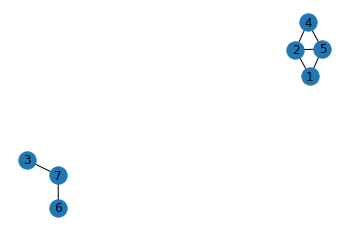

In [5]:
G = nx.Graph()
vertices = [1,2, 3, 4, 5, 6, 7]
edges = [(1, 2), (1, 5), (2, 5), (2, 4), (3, 7), (4,5), (6, 7)]
G.add_nodes_from(vertices)
G.add_edges_from(edges)
labels = nx.draw_networkx(G, pos = nx.spring_layout(G))
plt.axis('off')
plt.show()

2,5,1,CLIQUE
back,4,CLIQUE
back,back,back,3,7,CLIQUE
back,back,6,7,CLIQUE
back,back,7,back,finished


C:\Users\saurabh\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


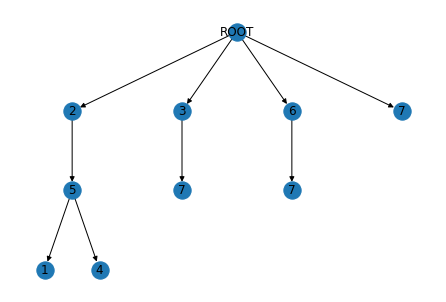

In [15]:
L = formatCliquesList(CLIQUES(G))
tree, pos, labels = createTree(L)
nx.draw(tree, pos=pos, labels=labels, with_labels=True)
plt.show()